<h1 align="center"><font size="5">Classification with Python</font></h1>

We load a dataset using the Pandas library, and apply various classification algorithms in machine learning, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load the required libraries:

In [ ]:
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

%matplotlib inline

### About dataset

This dataset is about past loans. The __loan_train.csv__ data set includes details of 346 customers whose loans are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off or in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Let's download the dataset

In [ ]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-11-05 12:30:35--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.02s   

2020-11-05 12:30:35 (1.03 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [ ]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [ ]:
print(f"The shape of the dataframe is: {df.shape}")

The shape of the dataframe is: (346, 10)


In [ ]:
df.dtypes

Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

### Convert to date time object 

In [ ]:
df[['due_date', 'effective_date']] = df[['due_date', 'effective_date']].astype('datetime64[ns]')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [ ]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to understand data better:


In [ ]:
df.describe()

,Unnamed: 0,Unnamed: 0.1,Principal,terms,age
count,346.000000,346.000000,346.000000,346.000000,346.000000
mean,202.167630,202.167630,943.641618,22.653179,30.939306
std,115.459715,115.459715,109.425530,7.991006,6.039418
min,0.000000,0.000000,300.000000,7.000000,18.000000
25%,107.250000,107.250000,900.000000,15.000000,27.000000
50%,204.500000,204.500000,1000.000000,30.000000,30.000000
75%,298.750000,298.750000,1000.000000,30.000000,35.000000
max,399.000000,399.000000,1000.000000,30.000000,51.000000


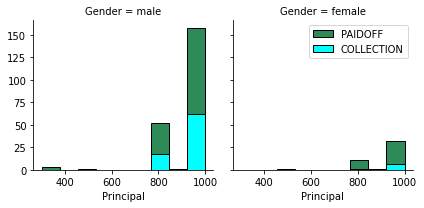

In [ ]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
pal = dict(PAIDOFF= 'seagreen', COLLECTION= 'aqua')  # a dictionary that maps the names of distinct values in the hue variable to valid matplotlib colors

g = sns.FacetGrid(df, col= "Gender", hue= "loan_status", palette= pal, col_wrap= 2)
g.map(plt.hist, 'Principal', bins= bins, ec= "k") # ec is short for edge color parameter

g.axes[-1].legend()
plt.show()

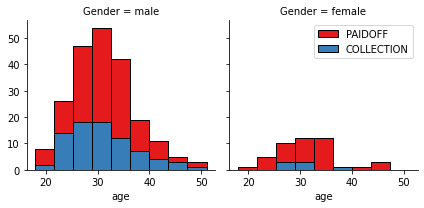

In [ ]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col= "Gender", hue="loan_status", palette= "Set1", col_wrap= 2)
g.map(plt.hist, 'age', bins=bins, edgecolor="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

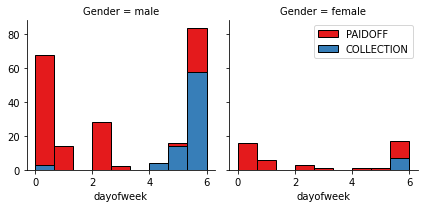

In [ ]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)

g = sns.FacetGrid(df, col= "Gender", hue= "loan_status", palette= "Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins= bins, ec= "k")

g.axes[-1].legend()
plt.show()

We see that almost all the customers who defaulted got the loan at the end of the week, so lets use Feature binarization to set a threshold value less than day 4.


In [ ]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert categorical features to numerical values

Lets look at gender:

In [ ]:
genGrpBy = df.groupby(['Gender'])['loan_status']
genGrpBy.value_counts(normalize= True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female paid their loans wrt only 73 % of males

Lets convert male to 0 and female to 1:


In [ ]:
df['Gender'].replace(to_replace= ['male','female'], value= [0, 1], inplace= True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [ ]:
df['education'].value_counts()

High School or Below    151
college                 149
Bechalor                 44
Master or Above           2
Name: education, dtype: int64

In [ ]:
df.groupby(['education'])['loan_status'].value_counts(normalize= True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding

In [ ]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature.head()

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1


#### Use one hot encoding technique to convert categorical varables to binary variables and append them to the Feature DataFrame 

In [ ]:
Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis= 1)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


In [ ]:
Feature.drop(['Master or Above'], axis = 1, inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Let's define the feature set, X:

In [ ]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [ ]:
y = df['loan_status'].to_numpy()
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization gives data with zero mean and unit variance (technically should be done after train test split )

In [ ]:
X= StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Let's use the training set to build an accurate model. Then use the test set to report the accuracy of the model.
We'll use the following algorithms:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression


## K Nearest Neighbor(KNN)
Let's find the best k to build the model with the best accuracy.  

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1)
print(f"Shape of training set feature matrix: {X_train.shape}")
print(f"Shape of test set feature matrix: {X_test.shape}")

Shape of training set feature matrix: (242, 8)
Shape of test set feature matrix: (104, 8)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k = np.arange(5, 14)
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']
param_grid_knn = dict(n_neighbors= k, algorithm= algo)

knn = KNeighborsClassifier(n_neighbors= k, n_jobs= -1)
clf_knn = GridSearchCV(knn, param_grid_knn, cv= 10, n_jobs= -1)
clf_knn.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=array([ 5,  6,  7,  8,  9, 10, 11, 12, 13]),
                                            p=2, weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
df_knn = pd.DataFrame(clf_knn.cv_results_)
df_knn[['param_algorithm', 'param_n_neighbors', 'mean_test_score']]

,param_algorithm,param_n_neighbors,mean_test_score
0,auto,5,0.719000
1,auto,6,0.673667
2,auto,7,0.711167
3,auto,8,0.694167
4,auto,9,0.698500
5,auto,10,0.690000
6,auto,11,0.665333
7,auto,12,0.689833
8,auto,13,0.693833
9,ball_tree,5,0.710833


In [ ]:
print(f"The best combination of knn parameters is: {clf_knn.best_params_}")
print(f"The mean cross-validated score of the best knn model is: {clf_knn.best_score_ : .6f}")

The best combination of knn parameters is: {'algorithm': 'auto', 'n_neighbors': 5}
The mean cross-validated score of the best knn model is:  0.719000


In [ ]:
yhat_knn = clf_knn.predict(X_test)
yhat_knn[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

impurity_metrics = ["gini", "entropy"]
param_grid_dt = dict(criterion= impurity_metrics)

clf_dt = GridSearchCV(DecisionTreeClassifier(), param_grid_dt, cv= 10, n_jobs= -1)
clf_dt.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy']},
             pre_di

In [ ]:
print(f"The best combination of Decision tree parameters is: {clf_dt.best_params_}")
print(f"The mean cross-validated score of the best Decision tree model is: {clf_dt.best_score_ : .6f}")

The best combination of Decision tree parameters is: {'criterion': 'gini'}
The mean cross-validated score of the best Decision tree model is:  0.640000


In [ ]:
yhat_dt = clf_dt.predict(X_test)
yhat_dt[0:5]

array(['COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC
# 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']

C_range = 10. ** np.arange(-3, 3)
gamma_range = 10. ** np.arange(-4, 1)

param_grid_svm = [{'kernel': ['rbf', 'poly'], 'C': C_range, 'gamma': gamma_range},
              {'kernel': ['linear'], 'C': C_range}]
              
# create a grid search classifier
clf_svm = GridSearchCV(SVC(), param_grid_svm, cv= 10, n_jobs= -1)
clf_svm.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid=[{'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'gamma': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                          'kernel': ['rbf', 'poly']},
                         {'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                          'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
df_svm = pd.DataFrame(clf_svm.cv_results_)
# df_svm
df_svm[['param_C', 'param_kernel', 'param_gamma', 'mean_test_score']]

,param_C,param_kernel,param_gamma,mean_test_score
0,0.001,rbf,0.0001,0.744000
1,0.001,poly,0.0001,0.744000
2,0.001,rbf,0.001,0.744000
3,0.001,poly,0.001,0.744000
4,0.001,rbf,0.01,0.744000
...,...,...,...,...
61,0.01,linear,NaN,0.744000
62,0.1,linear,NaN,0.744000
63,1,linear,NaN,0.723167
64,10,linear,NaN,0.702333


We can observe from *df_svm* that the best score for SVC model can be attained using either a RBF or Linear kernel function with the parameter settings such as {C= 1, gamma= .01} & {C= 0.1} respectively.


In [ ]:
print(f"The best combination of SVM parameters is: {clf_svm.best_params_}")
print(f"The mean cross-validated score of the best SVM model is: {clf_svm.best_score_ : .6f}")

The best combination of SVM parameters is: {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
The mean cross-validated score of the best SVM model is:  0.744000


In [ ]:
yhat_svm = clf_svm.predict(X_test)
yhat_svm[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
params_grid_lr = dict(solver= solver_list, C= C_range)
lr = LogisticRegression(n_jobs= -1, random_state= 3)

clf_lr = GridSearchCV(lr, params_grid_lr, cv= 10, n_jobs= -1)
clf_lr.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=-1, penalty='l2',
                                          random_state=3, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
df_lr = pd.DataFrame(clf_lr.cv_results_)
df_lr[['param_C', 'param_solver', 'mean_test_score']]

,param_C,param_solver,mean_test_score
0,0.001,liblinear,0.661000
1,0.001,newton-cg,0.744000
2,0.001,lbfgs,0.744000
3,0.001,sag,0.744000
4,0.001,saga,0.744000
5,0.01,liblinear,0.673500
6,0.01,newton-cg,0.744000
7,0.01,lbfgs,0.744000
8,0.01,sag,0.744000
9,0.01,saga,0.744000


In [ ]:
print(f"The best combination of LR parameters is: {clf_lr.best_params_}")
print(f"The mean cross-validated score of the best Logistic Regression model is: {clf_lr.best_score_ : .6f}")

The best combination of LR parameters is: {'C': 0.001, 'solver': 'newton-cg'}
The mean cross-validated score of the best Logistic Regression model is:  0.744000


In [ ]:
yhat_lr = clf_lr.predict(X_test)
yhat_lr[0 :5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

Checking Jaccard similarity score using the validation set for various classifiers:

In [ ]:
yhat_list = [yhat_knn, yhat_dt, yhat_svm, yhat_lr]
jac_val_set_list = []
for yhat in yhat_list:
  jac_val_set_list.append(jaccard_similarity_score(y_test, yhat))

print("The Jaccard Similarity scores on the validation set for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:\n")
for score in jac_val_set_list:
  print(f"{score : .3f}")

The Jaccard Similarity scores on the validation set for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:

 0.798
 0.712
 0.769
 0.769


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# Model Evaluation using Test set

First, download and load the test set:

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-11-05 12:31:21--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2020-11-05 12:31:21 (469 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [ ]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [ ]:
print(F"The shape of test set is: {test_df.shape}")
test_df.dtypes

The shape of test set is: (54, 10)


Unnamed: 0         int64
Unnamed: 0.1       int64
loan_status       object
Principal          int64
terms              int64
effective_date    object
due_date          object
age                int64
education         object
Gender            object
dtype: object

In [ ]:
# convert to datetime object  
test_df[['effective_date', 'due_date']] = test_df[['effective_date', 'due_date']].astype('datetime64[ns]')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male


We can see below that there are no missing values in test dataset:

In [ ]:
test_df.isna().sum()

Unnamed: 0        0
Unnamed: 0.1      0
loan_status       0
Principal         0
terms             0
effective_date    0
due_date          0
age               0
education         0
Gender            0
dtype: int64

In [ ]:
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,female,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,male,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,female,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,male,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,male,6,1


## Convert categorical features to numerical values

In [ ]:
genGrpBy_test = test_df.groupby(['Gender'])['loan_status']
genGrpBy_test.value_counts(normalize= True)

Gender  loan_status
female  PAIDOFF        0.727273
        COLLECTION     0.272727
male    PAIDOFF        0.744186
        COLLECTION     0.255814
Name: loan_status, dtype: float64

As more no. of males paid off their loans wrt females, let's encode males as 1 & females as 0.  

In [ ]:
test_df['Gender'].replace(to_replace= ['male', 'female'], value= [1, 0], inplace= True)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,0,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,1,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,0,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,1,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,1,6,1


In [ ]:
test_df.groupby(['education'])['loan_status'].value_counts(normalize= True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [ ]:
features_df =  test_df[['Principal', 'terms', 'age', 'Gender', 'weekend']]
features_df.head()

,Principal,terms,age,Gender,weekend
0,1000,30,50,0,0
1,300,7,35,1,1
2,1000,30,43,0,1
3,1000,30,26,1,1
4,800,15,29,1,1


In [ ]:
features_df = pd.concat([ features_df, pd.get_dummies(test_df['education']) ], axis= 1)
features_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,50,0,0,1,0,0,0
1,300,7,35,1,1,0,0,1,0
2,1000,30,43,0,1,0,1,0,0
3,1000,30,26,1,1,0,0,0,1
4,800,15,29,1,1,1,0,0,0


In [ ]:
features_df.drop(['Master or Above'], axis= 1, inplace= True)
features_df.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,0,0,1,0,0
1,300,7,35,1,1,0,0,0
2,1000,30,43,0,1,0,1,0
3,1000,30,26,1,1,0,0,1
4,800,15,29,1,1,1,0,0


In [ ]:
test_X = features_df
print(test_X[0: 5])
test_y = test_df['loan_status'].to_numpy()
test_y[0: 5]

   Principal  terms  age  ...  Bechalor  High School or Below  college
0       1000     30   50  ...         1                     0        0
1        300      7   35  ...         0                     0        0
2       1000     30   43  ...         0                     1        0
3       1000     30   26  ...         0                     0        1
4        800     15   29  ...         1                     0        0

[5 rows x 8 columns]


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [ ]:
# Normalize test set
test_X = StandardScaler().fit(test_X).transform(test_X)
test_X[0: 5]

array([[ 0.49362588,  0.92844966,  3.05981865, -1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596, -1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057,  0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942,  0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [ ]:
y_pred_list= []
clf_list= [clf_knn, clf_dt, clf_svm, clf_lr]

for clf in clf_list:
  y_pred = clf.predict(test_X)
  y_pred_list.append(y_pred)

In [ ]:
jaccard_list= []
for y_pred in y_pred_list:
  jac_score= jaccard_similarity_score(test_y, y_pred)
  jaccard_list.append(jac_score)

print(f"The Jaccard Similarity score on the test set for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:\n")
for score in jaccard_list:
  print(f"{score: .3f}")

The Jaccard Similarity score on the test set for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:

 0.667
 0.704
 0.741
 0.741


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


In [ ]:
f1_score_list= []
for y_pred in y_pred_list:
  score= f1_score(test_y, y_pred, pos_label= 'PAIDOFF')
  f1_score_list.append(score)

print(f"The F1 score for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:\n")
for acc_score in f1_score_list:
  print(f"{acc_score: .3f}")

The F1 score for Knn, Decision Tree, SVM & Logistic Regression classifiers respectively are:

 0.791
 0.784
 0.851
 0.851


In [ ]:
y_pred_prob = clf_lr.predict_proba(test_X)
loss = log_loss(test_y, y_pred_prob)
print(f"The Log Loss score for Logistic Regression classifier is: {loss : .3f}")

The Log Loss score for Logistic Regression classifier is:  0.565


# Report
The accuracy of the built models using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | 0.667       | 0.791        | NA      |
| Decision Tree      | 0.704       | 0.784        | NA      |
| SVM                | 0.741       | 0.851        | NA      |
| LogisticRegression | 0.741       | 0.851        | 0.565   |